## Probe Generalisation MVP

### Goals:
- [x] Choose a layer to train linear probes at
  - For now, we're doing layer 5, since that's the earliest layer that got perfect accuracy in the initial probe exploration
- [x] For each category in the 19th Feb dataset, train a linear probe
- [ ] Generate a heatmap plot, where the (x, y)-th entry is the accuracy of the probe trained on x data, predicted on y data
- [ ] Understand GPU capacity - can we do inference with 70B?

### Timeline:
- 19/02/25 and 20/02/25

In [8]:
# Imports
import torch
from models_under_pressure.probes import (
    create_activations,
    train_single_layer,
    compute_accuracy,
)

from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

project_root = Path("..").resolve()

In [3]:
# Loading dataset
df = pd.read_csv(project_root / "temp_data/dataset_19_feb.csv")

# Split data by top category
categories = {}
for category in df["top_category"].unique():
    category_df = df[df["top_category"] == category]
    categories[category] = {
        "X": category_df["prompt_text"].tolist(),
        "y": category_df["high_stakes"].tolist(),
    }


In [5]:
# Loading model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "meta-llama/Llama-3.3-70B-Instruct"
cache_dir = '/scratch/ucabwjn/.cache'
device = 'cuda:0'

# Load the LLaMA-3-1B model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             device_map="auto",
                                             max_memory={0: "80GB", 1: "80GB"},
                                             torch_dtype=torch.float16,
                                             cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Run the model on each category's data, recording the activations

for category in categories:
    categories[category]["acts"] = create_activations(
        model=model, tokenizer=tokenizer, text=categories[category]["X"], device=device
    )

Loading checkpoint shards: 100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


Layer: 0, Activation Shape: torch.Size([100, 33, 8192])
Layer: 1, Activation Shape: torch.Size([100, 33, 8192])
Layer: 2, Activation Shape: torch.Size([100, 33, 8192])
Layer: 3, Activation Shape: torch.Size([100, 33, 8192])
Layer: 4, Activation Shape: torch.Size([100, 33, 8192])
Layer: 5, Activation Shape: torch.Size([100, 33, 8192])
Layer: 6, Activation Shape: torch.Size([100, 33, 8192])
Layer: 7, Activation Shape: torch.Size([100, 33, 8192])
Layer: 8, Activation Shape: torch.Size([100, 33, 8192])
Layer: 9, Activation Shape: torch.Size([100, 33, 8192])
Layer: 10, Activation Shape: torch.Size([100, 33, 8192])
Layer: 11, Activation Shape: torch.Size([100, 33, 8192])
Layer: 12, Activation Shape: torch.Size([100, 33, 8192])
Layer: 13, Activation Shape: torch.Size([100, 33, 8192])
Layer: 14, Activation Shape: torch.Size([100, 33, 8192])
Layer: 15, Activation Shape: torch.Size([100, 33, 8192])
Layer: 16, Activation Shape: torch.Size([100, 33, 8192])
Layer: 17, Activation Shape: torch.Size([

In [27]:
model_params = {"C": 1, "random_state": 42, "fit_intercept": False}

# For each category, train a linear probe on the activations for layer 5:
for category in categories:
    # categories[category]["probes"] = [train_single_layer(
    #     categories[category]["acts"][5], categories[category]["y"], model_params
    # )
    categories[category]['probes'] = Parallel(n_jobs=16)(
    delayed(train_single_layer)(acts, categories[category]['y'], model_params) for acts in categories[category]["acts"]
)

accuracies = []
for cat1 in categories:
    for cat2 in categories:
        accuracy = [compute_accuracy(
            probe=probe, #categories[cat1]["probe"],
            activations=acts, #categories[cat2]["acts"][5],
            labels=categories[cat2]["y"],
        ) for probe, acts in zip(categories[cat1]["probes"], categories[cat2]["acts"])]
        accuracies.append(
            {
                "probe": cat1,
                "dataset": cat2,
                "accuracy": accuracy,
            }
        )
accuracies = pd.DataFrame(accuracies)

Notes:

- We need to fix y axis labels and make it clear which axis is probes and which is dataset
- We need a better colour scheme: red should be bad!
- Clearly communicate the experimental procedure
- Put all of this in a doc with some time before the meeting tomorrow (20th Feb)


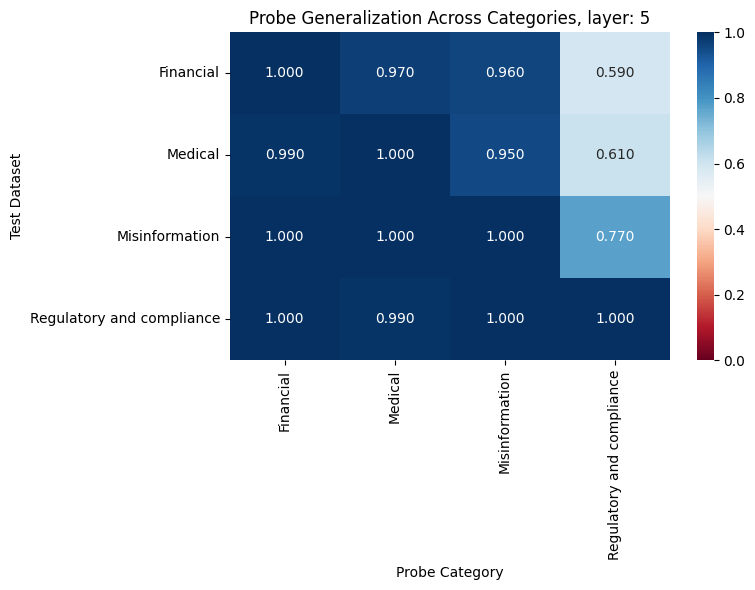

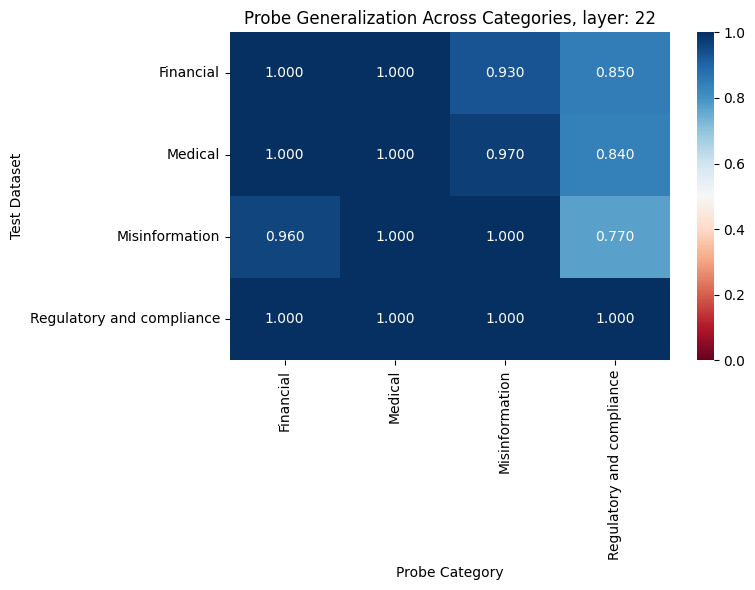

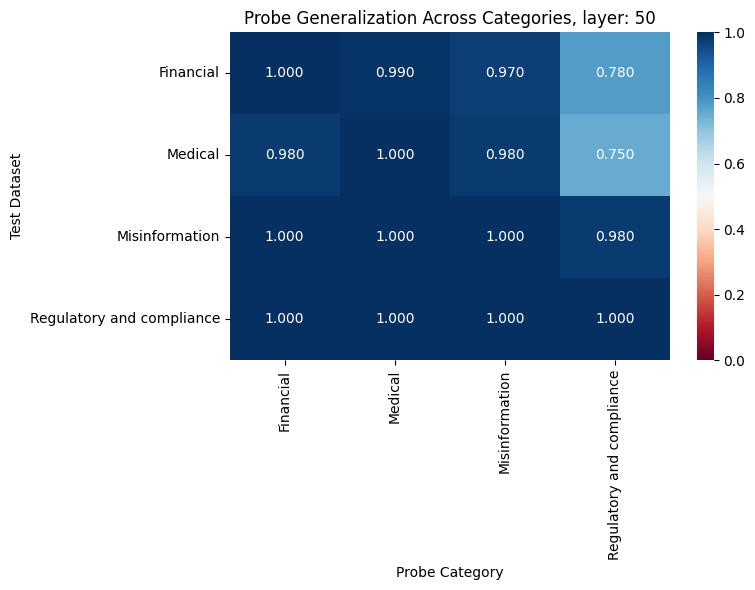

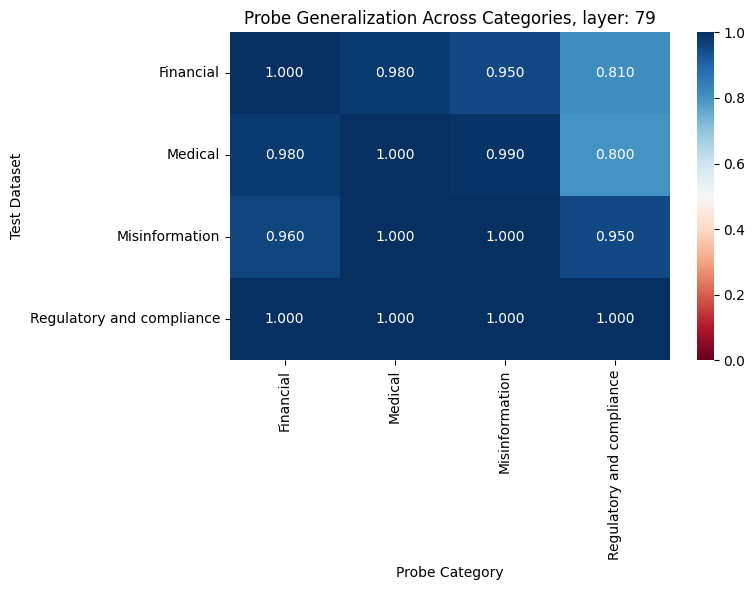

In [28]:
# Plot the categories[category]['accuracy'] values in a heatmap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

layers = [5, 22, 50, 79]


for layer in layers: 

    accuracies[f'layer_{layer}_accuracy'] = accuracies['accuracy'].apply(lambda x: x[layer])
    # Pivot the accuracies DataFrame to create a matrix
    accuracy_matrix = accuracies.pivot(index="dataset", columns="probe", values=f"layer_{layer}_accuracy")

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        accuracy_matrix,
        annot=True,  # Show values in cells
        fmt=".3f",  # Format numbers to 3 decimal places
        cmap="RdBu",  # Red (0) to Blue (1)
        vmin=0,  # Force scale to start at 0
        vmax=1,  # Force scale to end at 1
    )

    plt.title(f"Probe Generalization Across Categories, layer: {layer}")
    plt.xlabel("Probe Category")
    plt.ylabel("Test Dataset")
    plt.tight_layout()

    plt.savefig(project_root / "plots/probe_generalisation_heatmap.png")
    plt.show()
